Connected to remoteApi server.


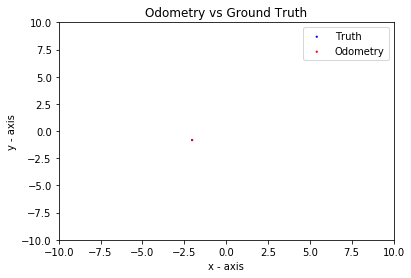

 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
AQUI:
[-2.031693696975708, -0.8254381418228149, 0.13867536187171936]
AQUI:
[-2.031696081161499, -0.8254407644271851, 0.13867321610450745]
AQUI:
[-2.0316977500915527, -0.8254382014274597, 0.1386774480342865]
AQUI:
[-2.031696081161499, -0.8254365921020508, 0.13867925107479095]
AQUI:
[-2.031691312789917, -0

AQUI:
[1.8972103595733643, -1.0744637250900269, 0.13866502046585083]
AQUI:
[1.9409821033477783, -1.0773749351501465, 0.13865533471107483]
AQUI:
[1.9847605228424072, -1.080284833908081, 0.13864943385124207]
AQUI:
[2.0285298824310303, -1.0831879377365112, 0.13866345584392548]
AQUI:
[2.0723042488098145, -1.0861002206802368, 0.13866472244262695]
AQUI:
[2.1161041259765625, -1.08901846408844, 0.1386360228061676]
AQUI:
[2.159865140914917, -1.0919256210327148, 0.13865134119987488]
AQUI:
[2.203629970550537, -1.0948609113693237, 0.1386568248271942]
AQUI:
[2.2473862171173096, -1.0977630615234375, 0.1386772245168686]
AQUI:
[2.2911715507507324, -1.1006712913513184, 0.13864180445671082]
AQUI:
[2.33494234085083, -1.1035817861557007, 0.13865111768245697]
AQUI:
[2.3786845207214355, -1.1064891815185547, 0.13866373896598816]
AQUI:
[2.4224648475646973, -1.1093919277191162, 0.13864368200302124]
AQUI:
[2.4662234783172607, -1.1123205423355103, 0.13869407773017883]
AQUI:
[2.5099892616271973, -1.11521613597869

AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496002197, -0.8249986171722412, 0.13879306614398956]
AQUI:
[-2.0249979496

KeyboardInterrupt: 

In [11]:
import sys
sys.path.insert(0, '../lib')
import vrep
import math
import time
import matplotlib.pyplot as plt
import numpy as np

vrep.simxFinish(-1)
clientID=vrep.simxStart('127.0.0.1',19997,True,True,5000,5)
if clientID != -1:
    print("Connected to remoteApi server.")
    ret1, motorLeft=vrep.simxGetObjectHandle(clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
    ret2, motorRight=vrep.simxGetObjectHandle(clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)

    ret3, robot_handle = vrep.simxGetObjectHandle(clientID, "Pioneer_p3dx", vrep.simx_opmode_oneshot_wait)
    
    ret10, floor_handle = vrep.simxGetObjectHandle(clientID, "ResizableFloor_5_25", vrep.simx_opmode_oneshot_wait)

    ret4, previousJointPosition=vrep.simxGetJointPosition(clientID,motorLeft,vrep.simx_opmode_streaming)
    ret5, previousJointPositionR=vrep.simxGetJointPosition(clientID,motorRight,vrep.simx_opmode_streaming)
    totalJointPosition=0
    odometry=[0,0]
    ang=0
    ret8, previousPosition=vrep.simxGetObjectPosition(clientID, robot_handle,-1,vrep.simx_opmode_oneshot_wait)
    # function to show the plot 
    plt.ion()
    fig, ax = plt.subplots()
    x, y = [],[]
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('y - axis') 
    x=[previousPosition[0],previousPosition[0]]
    y=[previousPosition[1],previousPosition[1]]
    # giving a title to my graph 
    plt.title('Odometry vs Ground Truth')   

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.draw()
    color=['blue','red']
    l1=['Truth','Odometry']
    sc =ax.scatter(x[0],y[0],s=5, edgecolors='none', c=color[0], label=l1[0])
    sc =ax.scatter(x[1],y[1],s=5, edgecolors='none', c=color[1], label=l1[1])
    fig.canvas.draw()
    ax.legend()
    plt.show()

    v0=2

    us_handle = []
    sensor_name=[]
    for i in range(0,16):
        sensor_name.append("Pioneer_p3dx_ultrasonicSensor"+str(i+1))
        res, handle = vrep.simxGetObjectHandle(clientID, sensor_name[i], vrep.simx_opmode_oneshot_wait)
        if(res != vrep.simx_return_ok):
            print ("\033[93m "+ sensor_name[i] + " not connected.")
        else:
            print ("\033[92m "+ sensor_name[i] + " connected.")
            us_handle.append(handle)
    
    #diametro da roda = 195mm; comprimento do eixo = 381mm
    radius=0.195/2
    L=0.381/2
    #vrep.simxSetJointTargetVelocity(clientID,motorLeft,0,vrep.simx_opmode_streaming)
    #vrep.simxSetJointTargetVelocity(clientID,motorRight,0,vrep.simx_opmode_streaming)
    while(v0>0):
        jl, actualJointPosition=vrep.simxGetJointPosition(clientID,motorLeft,vrep.simx_opmode_buffer)
        jr, actualJointPositionR=vrep.simxGetJointPosition(clientID,motorRight,vrep.simx_opmode_buffer)
        dxL=actualJointPosition-previousJointPosition
        dxR=actualJointPositionR-previousJointPositionR
        
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi

        
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
            
        ret4, previousJointPosition=vrep.simxGetJointPosition(clientID,motorLeft,vrep.simx_opmode_oneshot)
        ret5, previousJointPositionR=vrep.simxGetJointPosition(clientID,motorRight,vrep.simx_opmode_oneshot)
        #vrep.simxSetFloatSignal(clientID,"leftEncoder",totalJointPosition,vrep.simx_opmode_oneshot_wait)
        ret9, position=vrep.simxGetObjectPosition(clientID, robot_handle,-1,vrep.simx_opmode_oneshot_wait)
        newposition=math.sqrt(math.pow(previousPosition[0]-position[0],2)+math.pow(previousPosition[1]-position[1],2))
        
        j = [round(dxL,3),round(dxR,3)]
        #print(j)
        #if (round(dxR,3) != round(dxL,3)):
        ang=ang-(radius*dxL/(2*L))+(radius*dxR/(2*L))
        #else:
          #ang=ang
        dist0=(radius*dxL/2)+(radius*dxR/2)

        rotXY=np.dot(np.array([[math.cos(ang),-math.sin(ang)],[math.sin(ang),math.cos(ang)]]),np.array([[dist0],[0]]))
        transXY=np.array([[rotXY[0][0]+previousPosition[0]],[rotXY[1][0]+previousPosition[1]]])
        previousPosition=[transXY[0][0],transXY[1][0]]
        x=[position[0],transXY[0][0]]
        y=[position[1],transXY[1][0]]
        color=['blue','red']
        l1=['Truth','Odometry']
        sc =ax.scatter(x,y,s=5, edgecolors='none', c=color, label=l1)
        fig.canvas.draw()

        distances=[]
        for sensor in us_handle:
            res, status, distance,_,_ = vrep.simxReadProximitySensor(clientID, sensor, vrep.simx_opmode_streaming)
            distances.append(distance[2])
        angular=[90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90]
        #print(distances)
        for i in range(0,16):
            if (distances[i] > 0):
                angulars=ang+math.radians(angular[i]);
                rotXY=np.dot(np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]]),np.array([[distances[i]],[0]]))
                transXY=np.array([[rotXY[0][0]+position[0]],[rotXY[1][0]+position[1]]])
                x=[transXY[0][0]]
                y=[transXY[1][0]]
                sc =ax.scatter(x,y,s=1, edgecolors='none', c='cyan', alpha=0.6)

        time.sleep(0.01)
        [a, b] = vrep.simxGetObjectPosition(clientID,robot_handle,floor_handle,vrep.simx_opmode_blocking)
        print("AQUI:")
        print(b)

else:
    vrep.simxFinish(clientID)
    sys.exit("\033[91m ERROR: Unable to connect to remoteApi server. Consider running scene before executing script.")
